# Modelo de 5 cuerpos del sistema solar exterior


Consideraremos un modelo del sistema solar exterior de 5 masas puntuales: El sol (masa puntual localizada en el centro de masas del sistema solar interior), Jupiter, Saturno, Urano, y Neptuno que se mueven según la ley de gravedad de Newton.


<ul id="top">
<li><a href="#Carga-de-paquetes-y-funciones">Carga de paquetes y funciones</a></li>
<li><a href="#1-Definición-del-modelo-matemático-del-problema-de-$N$-cuerpos">1-Definición del modelo matemático del problema de $N$ cuerpos</a></li>
<li><a href="#2-Solución-del-modelo-matemático-del-sistema-solar-exterior">2-Solución del modelo matemático del sistema solar exterior</a></li>  
<li><a href="#3-Evolución-del-error-en-energía">3- Evolución del error en energía</a></li> 
<li><a href="#4-Estimación-del-error-en-posiciones">4-Estimación del error en posiciones</a></li>     
</ul>


## Carga de paquetes y funciones

In [1]:
using LinearAlgebra
using Plots
using OrdinaryDiffEq
using IRKGaussLegendre

In [2]:
include("DatosInicialesSistemaSolar.jl");

<a href="#top">Volver al inicio</a>

## 1-Definición del modelo matemático del problema de $N$ cuerpos


**Ecuaciones**

La energía del sistema como función de las posiciones $q_1,\ldots,q_N \in \mathbb{R}^3$ y de las velocidades $v_1,\ldots,v_N \in \mathbb{R}^3$ de los $N$ cuerpos es:

\begin{equation*}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{equation*}


El módelo matemático se define con el siguiente sistema de ecuaciones diferenciales:

\begin{equation}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split} \tag{1}
\end{equation}


El sistema se puede escribir de forma compacta como:

\begin{equation*}
\frac{d u}{dt} = f(t,u,p), \quad u(t_0)=u_0. \tag{2}
\end{equation*}



**Variables de estado y parámetros**


Representaremos las variables de estado  como un array con tres indices:

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{3\times N \times 2}, 
\end{equation*}

siendo $u[i,j,k] \in \mathbb{R}$:

- El indice $i$ toma los valores $i=1,2,3$, haciendo referencia a la coordenada $x,y,z$ respectivamente.
- El indice $j$ toma los valores $j=1,2,\dots,N$, haciendo referencia al planeta correspondiente.
- El indice $k$ toma los valores $k=1,2$, haciendo referencia a la posición si $k=1$  y a la velocidad si $k=2$.

El vector con los parámetros constantes del problema es:

\begin{equation*}
p = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N,
\end{equation*}

donde $Gm_i$ corresponde a la masa del cuerpo $i$ multiplicado por la constante de la gravedad universal $G$.

**Unidades de medida:** 

Mediremos la distancia en la unidad astronómica (AU), y el tiempo en días.

A continuación implementamos la función NbodyEnergy(u,p) que devuelve la energía del sistema multiplicado por $G$.

In [3]:
# u -> tensor tal que:
#  i: 1, 2, 3        => x, y, z
#  j: 1, 2, ..., N   => cuerpo
#  k: 1, 2           => [ 1 -> pos | 2 -> vel ]

function NbodyEnergy(u,p)
     N = length(p)
     T = 0.
     U = 0.
     for i in 1:N
        qi = u[:, i, 1] # pos
        vi = u[:, i, 2] # vel
        Gmi = p[i]
        T += Gmi * norm(vi)^2
        for j in (i+1):N
           qj = u[:, j, 1] # pos
           Gmj = p[j]
           qij = qi - qj
           U -= Gmi*Gmj/norm(qij)
        end
     end
    
    return 1/2*T + U
end


NbodyEnergy (generic function with 1 method)

Seguidamente implementamos la función NbodyODE!(du,u,p,t) correspondiente al sistema (1). 

In [4]:
function NbodyODE!(du,u,p,t)

    N = length(p)
    du[:,:,2] .= 0
    for i in 1:N

        xi = u[1, i, 1]
        yi = u[2, i, 1]
        zi = u[3, i, 1]

        Gmi = p[i] 
        for j in (i+1):N

            xij = xi - u[1, j, 1]
            yij = yi - u[2, j, 1]
            zij = zi - u[3, j, 1]

            Gmj = p[j] 
            dotij = xij^2+yij^2+zij^2
            auxij = 1/(sqrt(dotij)*dotij) 
            dotij = xij^2+yij^2+zij^2
            invdotij = 1/dotij
            sqrtinvdotij = sqrt(invdotij) 
            auxij = invdotij * sqrtinvdotij 
            du[1,i,2] -= Gmj*auxij*xij
            du[1,j,2] += Gmi*auxij*xij
            du[2,i,2] -= Gmj*auxij*yij
            du[2,j,2] += Gmi*auxij*yij
            du[3,i,2] -= Gmj*auxij*zij
            du[3,j,2] += Gmi*auxij*zij
        end
    end
    
    for i in 1:3, j in 1:N
        du[i,j,1] = u[i, j, 2]
    end
    return nothing
end


NbodyODE! (generic function with 1 method)

<a href="#top">Volver al inicio</a>

## 2-Solución del modelo matemático del sistema solar exterior
 

La función **DatosInicialesSistemaSolarExt()** nos devuelve:

- el estado inicial $u_0$ del sistema el 28 de junio de 1969 (Julian day (TDB) 2440400.5, obtenidos de la efemérides DE430), 
- los datos de $G\, m_i$ para cada cuerpo $i=1,2,3,4,5$, y 
- una lista de strings identificativos de cada cuerpo. 

In [5]:
u0, p, bodylist = DatosInicialesSistemaSolarExt()
N = length(p)
bodylist

1×5 Matrix{String}:
 "SS interior"  "Jupiter"  "Saturno"  "Urano"  "Neptuno"

### Ejercicio

- Mostrar las coordenadas iniciales de la posición de Urano:

In [6]:
(u0[1, 4, 1], u0[2, 4, 1], u0[3, 4, 1]) # u0[:, 4, 1]  x, y, z

(-18.265402478119373, -1.1619554252029907, -0.250105992222027)



A continuación obtendremos los resultados del modelo del sistema solar exterior en el intervalo $t \in [0,60182]$. Para ello integraremos dicho modelo utilizando:

- **Método de integración** de orden $16$: IRKGL16()
- **Intervalo de integración**: $(0, 60182)$,  periodo aproximado de Neptuno en días
- **Longitud de paso**: $h=800$
- **Integración de paso constante**:  $adaptive=false$
- $mstep=2$: para indicar que queremos obtener los resultados cada dos pasos, es decir:  $t_0, \ t_{2h}, \ t_{4h}, \dots, t_f$

In [7]:
tspan = (0.,60182.)
prob = ODEProblem(NbodyODE!, u0, tspan, p)
h = 800.
sol =  solve(prob, IRKGL16(mstep=2), adaptive=false, dt=h)
sol.retcode 

ReturnCode.Success = 1

In [8]:
sol.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  12104
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1513
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          76
Number of rejected steps:                          0

Obtendremos tres figuras (correspondientes a las proyecciones en el plano OXY, OXZ, y OYZ, respectivamente) con las gráficas de las  de las órbitas de los cuatro planetas exteriores.

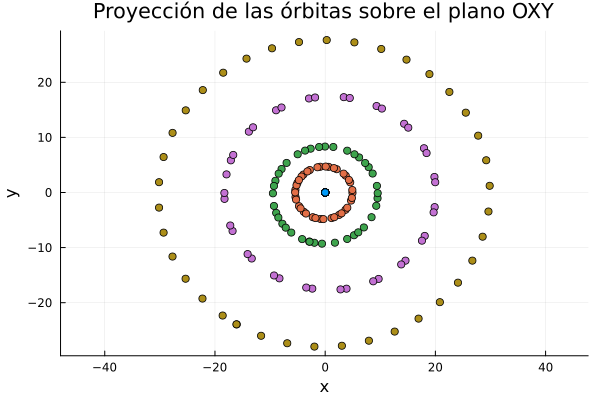

In [9]:
pl = plot(title="Proyección de las órbitas sobre el plano OXY", 
            xlabel="x", ylabel="y", legend=false, aspect_ratio=1)

  for j = 1:5
    x  = [u[1, j, 1] for u in sol.u]
    y  = [u[2, j, 1] for u in sol.u] 
    pl = scatter!(x,y) 
  end 
display(pl)

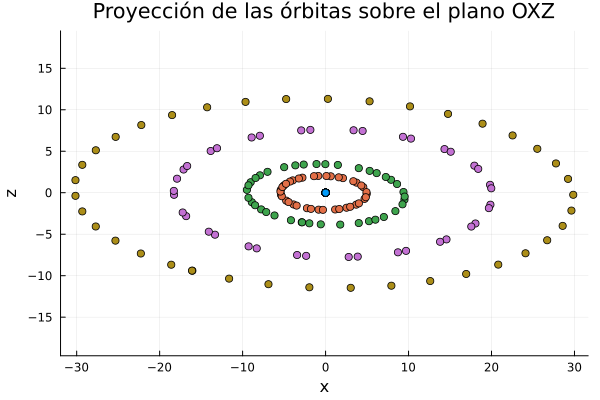

In [10]:
pl = plot(title="Proyección de las órbitas sobre el plano OXZ", 
            xlabel="x", ylabel="z", legend=false, aspect_ratio=1)

  for j = 1:5
    x  = [u[1, j, 1] for u in sol.u]
    z  = [u[3, j, 1] for u in sol.u] 
    pl = scatter!(x,z) 
  end 
display(pl)

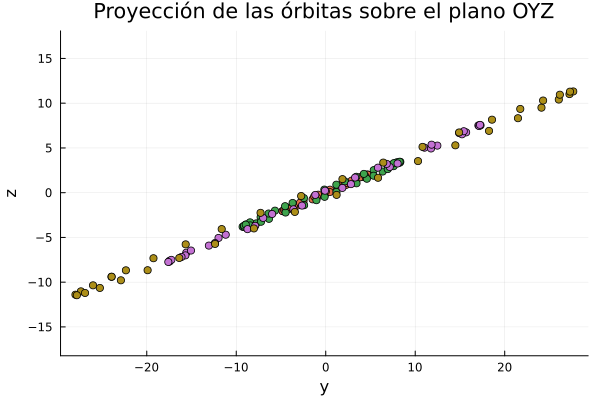

In [11]:
pl = plot(title="Proyección de las órbitas sobre el plano OYZ", 
            xlabel="y", ylabel="z", legend=false, aspect_ratio=1)

  for j = 1:5
    y  = [u[2, j, 1] for u in sol.u]
    z  = [u[3, j, 1] for u in sol.u] 
    pl = scatter!(y,z) 
  end 
display(pl)

<a href="#top">Volver al inicio</a>

## 3- Evolución del error en energía

Representaremos la evolución del (valor absoluto del) error relativo en energía en escala logarítmica.

El error en energia en $t=t_k$ es $$ \left| \frac{E(u_k,p)-E(u_0,p)}{E(u_0,p)} \right|$$
donde $E(u_k,p)$ es la función que nos devuelve la energía de nuestro sistema.

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106


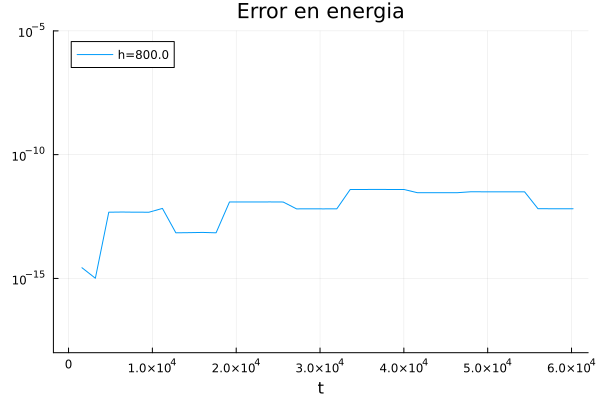

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106


In [12]:
E0 = NbodyEnergy(u0,p)
#EE = [ abs( (NbodyEnergy(u, p) - E0) / E0 ) for u in sol.u]
EE = [ NbodyEnergy(u, p) for u in sol.u]
EE = abs.((EE .-E0 ) ./ E0)


pl = plot(sol.t, EE, 
          xlabel="t", title="Error en energia", 
          yscale=:log10, ylims=(1e-18,1e-5),
          label="h=$h", legend=:topleft )

<a href="#top">Volver al inicio</a>

## 4- Evolución del error en posiciones

En este apartado queremos mostrar en una misma figura la **evolución del error en posiciones de cada planeta**, para la solución aproximada obtenida con paso $h=800$. 


El error cometido en la solución aproximada $U(k,h)\approx u(t_0+hk)$ con paso $h$,   se puede estimar escalando de forma apropiada la diferencia entre la solución aproximada  $U(k,2h)\approx u(t_0+2hk)$ obtenida con paso $2h$ y la solución aproximada $U(k,h)\approx u(t_0+hk)$ con paso $h$:

\begin{align*}
  &\text{Para} \ k =1,2,3, \dots \\
  &\qquad U(2k,h)-u(t_0+2kh) \approx \frac{1}{2^r-1} (U(k.2h)-U(2k,h))
\end{align*}



**Primero**, calculamos la  solución aproximada  $U(k,2h)\approx u(t_0+2hk)$  con paso $2h$:

In [20]:
h2=2*h
sol2 =  solve(prob, IRKGL16(mstep=1), adaptive=false, dt=h2)
sol2.retcode

ReturnCode.Success = 1

**Segundo**, definimos una función que denominamos **ErroresPosicion(j)**,  que calcula la norma euclidea del error estimado en posiciones del planeta $j$:

In [24]:
r=16
factor=1/(2^r-1)

errores = factor*(sol2.u - sol.u)
ErroresPosicion(j) = [norm(e[:, j, 1]) for e in errores]

ErroresPosicion (generic function with 1 method)

**Tercero**, mostramos en una misma figura cuatro curvas con la evolución del error en posiciones de cada planeta:  

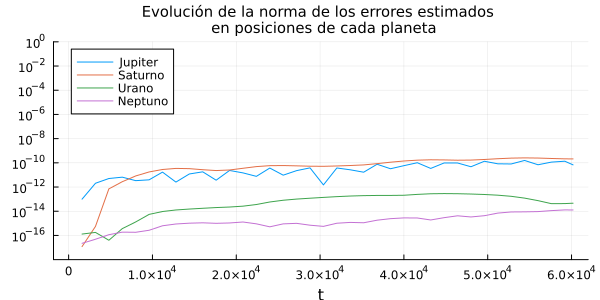

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/Ec1L1/src/utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plo

In [25]:
indices_planetas = 2:5

plt_err1=plot(sol.t, [ErroresPosicion(i) for i in indices_planetas],
              titlefontsize=10,  xlabel="t", yscale=:log10,  ylim=(1e-18,1e0), 
               labels=bodylist[:,indices_planetas], legend=:topleft,  yticks= 10. .^ (-16:2:0))

plot(plt_err1, layout=(1), size=(600,300),
     plot_titlefontsize=10,
     plot_titlevspan=0.1,
     plot_title="Evolución de la norma de los errores estimados \n en posiciones de cada planeta")